# The Deterministic Cake Eating Problem - Value Function Iteration with Interpolation Solution
### by [Jason DeBacker](http://jasondebacker.com), June 2018
This Jupyter notebook illustrates how to solve the deterministic cake eating problem using interpolation with value function iteration (VFI).

## The Problem:

$$V(w)=\max_{c} u(c)+\beta V(w'), \forall w\in[0,\bar{w}]$$

or, substituting in the law of motion: $w' = w - c$,

$$V(w)=\max_{0\leq w' \leq w}u(w-w')+\beta V(w'), \forall w$$

The unknowns in this system are functions: The value function, $V(w)$, and the policy function, $c = \phi(w)$ (or, equivalently, $w' = p(w)$).

## The Solution:

We'll solve this problem with value function iteration (VFI).  With this method, we'll use an iterative procedure to converge to a fixed point in function space, the true value function, $V(w)$.  

The computational algorithm for VFI is as follows:

1. Create a discrete grid of the state variable, $w$
2. Make an initial guess at the value function, $V_{0}(w)$
    * This will be a value for each point in the state space
3. Perform the operation:
$$TV(w) = \max_{w'}u(w-w') + \beta V_{0}(w')$$
4. Update the guess at the value function: $V_{1}(w) = TV(w)$
5. Repeat this process:
$$V_{i+1} \ (w) = TV(w) = \max_{w'}u(w-w') + \beta V_{i}(w)$$
6. Stop when, $|V_{i+1} \ (w)-V_{i}(w)|<\varepsilon$, where $\varepsilon$ is a small number.



In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.optimize import fminbound
import scipy.optimize as opt

# to print plots inline
%matplotlib inline

## Step 1: Set parameters and create grid for state space

Parameters:
* $\beta$ = rate of time preference
* $\sigma$ = coefficient of relative risk aversion (if $\sigma = 1$, $u(c)=log(c)$), parameter describes the curvature of the utility function

In [78]:
beta = 0.95
sigma = 1.0
R = 1.0 / beta

'''
------------------------------------------------------------------------
Create Grid for State Space    
------------------------------------------------------------------------
lb_w      = scalar, lower bound of cake grid
ub_w      = scalar, upper bound of cake grid 
size_w    = integer, number of grid points in cake state space
w_grid    = vector, size_w x 1 vector of cake grid points 
------------------------------------------------------------------------
'''
lb_w = 0.1 
ub_w = 1.0 
size_w = 200  # Number of grid points
w_grid = np.linspace(lb_w, ub_w, size_w)

In [79]:
def utility(w, wprime, sigma, R):
    """
    Per period utility function
    """
    C = w - wprime / R
    if sigma == 1:
        U = np.log(C)
    else:
        U = (C ** (1 - sigma)) / (1 - sigma)
    return U  

In [80]:
# write Bellman operator function to help with VFI
def bellman_operator(V, w_grid, params):
    '''
    The approximate Bellman operator, which computes and returns the
    updated value function TV on the grid points.  An array to store
    the new set of values TV is optionally supplied (to avoid having to
    allocate new arrays at each iteration).  If supplied, any existing data in 
    Tw will be overwritten.
    '''
    beta, sigma, R = params
    
    # Apply cubic interpolation to V
    V_func = interpolate.interp1d(w_grid, V, kind='cubic', fill_value='extrapolate')

    # Initialize array for operator and policy function
    TV = np.empty_like(V)
    optW = np.empty_like(TV)

    # == set TV[i] = max_w' { u(w,w') + beta V(w')} == #
    for i, w in enumerate(w_grid):
        def objective(wprime):
            return - utility(w, wprime, sigma, R) - beta * V_func(wprime)
        wprime_star = fminbound(objective, 1e-6, w - 1e-6)
        optW[i] = wprime_star
        TV[i] = - objective(wprime_star)
    return TV, optW

## Step 2: Value Function Iteration

In [86]:
'''
------------------------------------------------------------------------
Value Function Iteration    
------------------------------------------------------------------------
VFtol     = scalar, tolerance required for value function to converge
VFdist    = scalar, distance between last two value functions
VFmaxiter = integer, maximum number of iterations for value function
V         = vector, the value functions at each iteration
Vmat      = matrix, the value for each possible combination of w and w'
Vstore    = matrix, stores V at each iteration 
VFiter    = integer, current iteration number
V_params  = tuple, contains parameters to pass into Belman operator: beta, sigma
TV        = vector, the value function after applying the Bellman operator
PF        = vector, indicies of choices of w' for all w 
VF        = vector, the "true" value function
------------------------------------------------------------------------
'''
VFtol = 1e-8 
VFdist = 7.0 
VFmaxiter = 500 
V = np.zeros(size_w)#true_VF # initial guess at value function
Vstore = np.zeros((size_w, VFmaxiter)) #initialize Vstore array
VFiter = 1 
V_params = (beta, sigma, R)
while VFdist > VFtol and VFiter < VFmaxiter:
    Vstore[:, VFiter] = V
    TV, optW = bellman_operator(V, w_grid, V_params)
#     TV, optW = bellman_operator2(V, w_grid, beta, sigma)
    VFdist = (np.absolute(V - TV)).max()  # check distance
    print('Iteration ', VFiter, ', distance = ', VFdist)
    V = TV
    VFiter += 1

if VFiter < VFmaxiter:
    print('Value function converged after this many iterations:', VFiter)
else:
    print('Value function did not converge')            


VF = V # solution to the functional equation

Iteration  1 , distance =  2.30265739597
Iteration  2 , distance =  3.47010614024
Iteration  3 , distance =  3.66625016667
Iteration  4 , distance =  3.68236858945
Iteration  5 , distance =  3.63286901861
Iteration  6 , distance =  3.55209240236
Iteration  7 , distance =  3.45477338434
Iteration  8 , distance =  3.34850797883
Iteration  9 , distance =  3.23766537012
Iteration  10 , distance =  3.12494249762
Iteration  11 , distance =  3.01208345762
Iteration  12 , distance =  2.90025046888
Iteration  13 , distance =  2.79023139444
Iteration  14 , distance =  2.68256355162
Iteration  15 , distance =  2.5776110352
Iteration  16 , distance =  2.47561538526
Iteration  17 , distance =  2.37672938409
Iteration  18 , distance =  2.28104091981
Iteration  19 , distance =  2.18858995821
Iteration  20 , distance =  2.09938033112
Iteration  21 , distance =  2.0133890781
Iteration  22 , distance =  1.93057316496
Iteration  23 , distance =  1.85087448537
Iteration  24 , distance =  1.77422386953
Ite

Iteration  188 , distance =  0.000660869428231
Iteration  189 , distance =  0.000627859399657
Iteration  190 , distance =  0.000596498214222
Iteration  191 , distance =  0.000566703511993
Iteration  192 , distance =  0.000538397046952
Iteration  193 , distance =  0.000511504481551
Iteration  194 , distance =  0.000486277835648
Iteration  195 , distance =  0.000462002257933
Iteration  196 , distance =  0.000438938600354
Iteration  197 , distance =  0.000417026357127
Iteration  198 , distance =  0.000396208043455
Iteration  199 , distance =  0.000376429044479
Iteration  200 , distance =  0.000357637472163
Iteration  201 , distance =  0.000339784029109
Iteration  202 , distance =  0.000322821879209
Iteration  203 , distance =  0.000306706524725
Iteration  204 , distance =  0.000291395689572
Iteration  205 , distance =  0.000276849208362
Iteration  206 , distance =  0.000263028921012
Iteration  207 , distance =  0.000249898572733
Iteration  208 , distance =  0.000237423718687
Iteration  20

Iteration  363 , distance =  8.49435082273e-08
Iteration  364 , distance =  8.07050781759e-08
Iteration  365 , distance =  7.66781340644e-08
Iteration  366 , distance =  7.28521740712e-08
Iteration  367 , distance =  6.92171084893e-08
Iteration  368 , distance =  6.5763430257e-08
Iteration  369 , distance =  6.24821012707e-08
Iteration  370 , distance =  5.93644813307e-08
Iteration  371 , distance =  5.6402456039e-08
Iteration  372 , distance =  5.35882378472e-08
Iteration  373 , distance =  5.09144086891e-08
Iteration  374 , distance =  4.83740336676e-08
Iteration  375 , distance =  4.59604194702e-08
Iteration  376 , distance =  4.36672280557e-08
Iteration  377 , distance =  4.14884624433e-08
Iteration  378 , distance =  3.94184098695e-08
Iteration  379 , distance =  3.74516702095e-08
Iteration  380 , distance =  3.55830565013e-08
Iteration  381 , distance =  3.3807666e-08
Iteration  382 , distance =  3.2120865967e-08
Iteration  383 , distance =  3.05182510374e-08
Iteration  384 , dis

## Step 3: Extract decision rules from solution

In [66]:
'''
------------------------------------------------------------------------
Find consumption and savings policy functions   
------------------------|------------------------------------------------
optC  = vector, the optimal choice of c for each c
------------------------------------------------------------------------
'''
optC = w_grid - optW / R # optimal consumption - get consumption through the transition eqn

## Visualize output

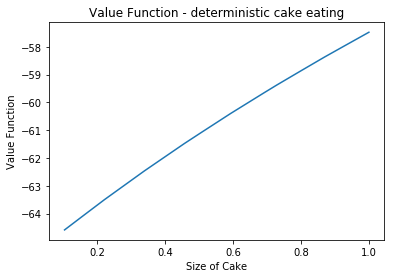

In [67]:
# Plot value function 
plt.figure()
plt.plot(w_grid[1:], VF[1:])
plt.xlabel('Size of Cake')
plt.ylabel('Value Function')
plt.title('Value Function - deterministic cake eating')
plt.show()

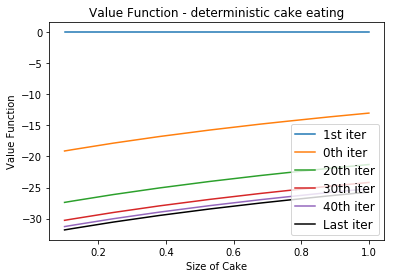

In [41]:
# Plot value function at several iterations
plt.figure()
fig, ax = plt.subplots()
ax.plot(w_grid, Vstore[:,0], label='1st iter')
ax.plot(w_grid, Vstore[:,10], label='0th iter')
ax.plot(w_grid, Vstore[:,20], label='20th iter')
ax.plot(w_grid, Vstore[:,30], label='30th iter')
ax.plot(w_grid, Vstore[:,40], label='40th iter')
ax.plot(w_grid, Vstore[:,VFiter-1], 'k', label='Last iter')
# Now add the legend with some customizations.
legend = ax.legend(loc='lower right', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Cake')
plt.ylabel('Value Function')
plt.title('Value Function - deterministic cake eating')
plt.show()

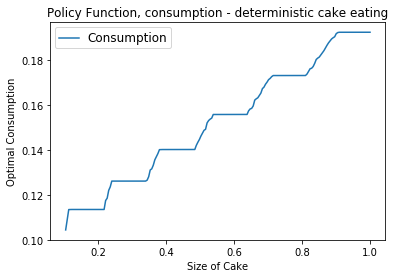

In [42]:
#Plot optimal consumption rule as a function of cake size
plt.figure()
fig, ax = plt.subplots()
ax.plot(w_grid[1:], optC[1:], label='Consumption')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper left', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Cake')
plt.ylabel('Optimal Consumption')
plt.title('Policy Function, consumption - deterministic cake eating')
plt.show()

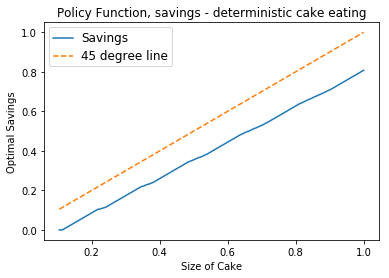

In [43]:
#Plot cake to leave rule as a function of cake size
plt.figure()
fig, ax = plt.subplots()
ax.plot(w_grid[1:], optW[1:], label='Savings')
ax.plot(w_grid[1:], w_grid[1:], '--', label='45 degree line')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper left', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Cake')
plt.ylabel('Optimal Savings')
plt.title('Policy Function, savings - deterministic cake eating')
plt.show()

## Finding approximation errors

It's a little complicated (we need to do the guess and verify method), but we can show that with $\sigma = 1.0$ (i.e., $u(c) = log(c)$), then the policy function is $w' = \beta w$.  Knowing this, we can find the approximation error from our solution method (VFI over a discrete grid).  This errors are found as:

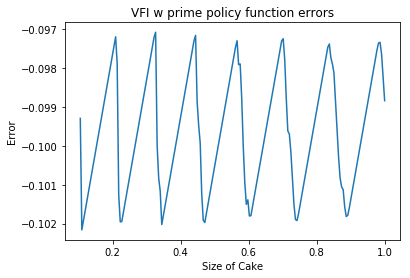

In [68]:
Wprime_errors = optW - beta * w_grid

# Plot policy function approximation errors
plt.figure()
plt.plot(w_grid[1:], Wprime_errors[1:])
plt.xlabel('Size of Cake')
plt.ylabel('Error')
plt.title('VFI w prime policy function errors')
plt.show()

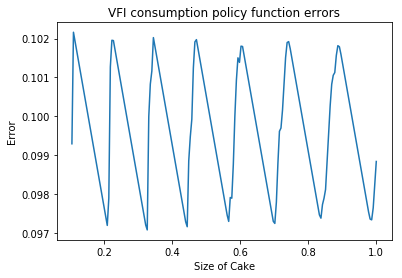

In [69]:
C_errors = optC - (1 - beta) * w_grid
# Plot policy function approximation errors
plt.figure()
plt.plot(w_grid[1:], C_errors[1:])
plt.xlabel('Size of Cake')
plt.ylabel('Error')
plt.title('VFI consumption policy function errors')
plt.show()

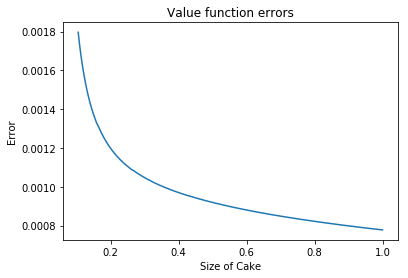

In [84]:
# Compute true value function if u(c)=log(c)
B = 1 / (1 - beta)
A = B * np.log(1 - beta) + B * B * beta * np.log(R * beta)
true_VF = A + B * np.log(w_grid)
VF_errors = VF - true_VF
# Plot value function approximation errors
plt.figure()
plt.plot(w_grid[1:], VF_errors[1:])
plt.xlabel('Size of Cake')
plt.ylabel('Error')
plt.title('Value function errors')
plt.show()

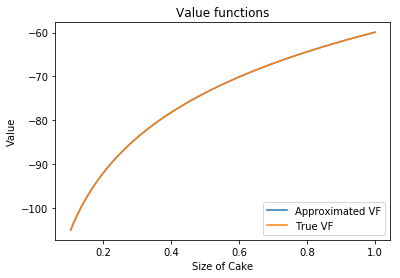

In [85]:
# Plot true and found value functions
plt.figure()
plt.plot(w_grid[1:], VF[1:], label='Approximated VF')
plt.plot(w_grid[1:], true_VF[1:], label='True VF')
plt.xlabel('Size of Cake')
plt.ylabel('Value')
plt.title('Value functions')
plt.legend(loc='lower right')
plt.show()